In [2]:
import tensorflow as tf
import numpy as np
from models._24_net import detect_24Net
from utils.params import *
from utils.utilities import *
import sys
from utils import save
from utils.sampling import GetSample
import time
from PIL import Image

In [2]:
get = GetSample()
pos_db_24 = get.get_pos_img(p_net_24)

Samples Checked..
IMG_INDEX:112/112
Finished


In [3]:
g = tf.Graph()
with g.as_default():
    input_24_node = tf.placeholder(tf.float32, [None, 24, 24, 3])
    target_24_node = tf.placeholder(tf.float32, [None, 1])
    keep_prob = tf.placeholder(tf.float32)
    learning_rate = tf.placeholder(tf.float32)
    det_net_24 = detect_24Net(input_24_node, target_24_node, keep_prob, learning_rate)

In [4]:
sess = tf.InteractiveSession(config=tf.ConfigProto(
  allow_soft_placement=True, log_device_placement=True), graph=g)
sess.run(tf.global_variables_initializer())
#train_writer = tf.summary.FileWriter('./logs/train/Det_24', sess.graph)

In [ ]:
inputs = np.zeros((p_batch_size ,p_net_24, p_net_24, 3))
targets = np.zeros((p_batch_size, 1))
pos_db_24 = save.loader('pos_db_24.txt')
neg_db_24 = save.loader('neg_db_24_filter.txt')
valid_db_24 = save.loader('valid_db_24.txt')

In [6]:
valid_input = np.array([arr[0] for arr in valid_db_24])
valid_target = np.array([arr[1] for arr in valid_db_24])

In [7]:
np.sum(valid_target == 1.0)

40

In [7]:
pred_arr = det_net_24.prediction_flatten.eval(feed_dict={input_24_node:valid_input, keep_prob:1.0})

In [ ]:
def detnet_evaluation(pred_arr, true_arr, thres=.5):
    pred_idx = np.where(pred_arr>thres)[0]
    pred_tf = (pred_arr>thres)*1
    #print(len(pred_idx))
    correct_idx = len(np.where(true_arr[pred_idx] == 1)[0]) # Predicted Positives that are true positive
    true_len = np.sum(true_arr == 1.0)
    
    correct_numb = np.sum((pred_tf==true_arr))
    return correct_idx / true_len, correct_idx/(len(pred_idx)+1e-7)

def f1_score(recall, precision, weight=1.0):
    a = weight**2
    return (a + 1)*recall*precision / a*(recall + precision)

In [9]:
reg = [0, 1e-4]
lr = [5e-5, 2.5e-5, 1e-5, 6e-6]
bias = [0.0]
epochs = 300
neg_db_24 = neg_db_24[:10080*2,:]

In [10]:
batch_len = int(neg_db_24.shape[0] / p_neg_batch)
total_iters = epochs * batch_len

for r in reg:
    for b in bias:
        for l in lr:
            record_l = l
            print('**Bias_init:{}   Learning_rate:{}   Regularization:{}**'.format(b,l,r))
            batch_sel_pos = batch_selection()
            batch_sel_neg = batch_selection()
            start = time.time()
            bad_cnt = 0
            max_epo = 0
            max_true_acc = 0
            max_recall = 0
            max_f1 = 0
            
            g = tf.Graph()
            with g.as_default():
                input_24_node = tf.placeholder(tf.float32, [None, 24, 24, 3])
                target_24_node = tf.placeholder(tf.float32, [None, 1])
                keep_prob = tf.placeholder(tf.float32)
                det_net_24 = detect_24Net(input_24_node, target_24_node, keep_prob, l, b, r)

            sess = tf.InteractiveSession(config=tf.ConfigProto(
              allow_soft_placement=True, log_device_placement=True), graph=g)
            sess.run(tf.global_variables_initializer())
            
            pred_arr = det_net_24.prediction_flatten.eval(feed_dict={input_24_node:valid_input, keep_prob:1.0})
            recall, true_acc = detnet_evaluation(pred_arr, valid_target, .5)
            f1 = f1_score(recall, true_acc)
            #train_writer = tf.summary.FileWriter('./logs/train/Det_24/lr={},b={}'.format(l,b), sess.graph)
            for epo in range(epochs):
                loss = 0
                
                if (epo+1) % 3 == 0:
                    pred_arr = det_net_24.prediction_flatten.eval(feed_dict={input_24_node:valid_input, keep_prob:1.0})
                    recall, true_acc = detnet_evaluation(pred_arr, valid_target, .5)
                    f1 = f1_score(recall, true_acc)
                    
                    if f1 >= max_f1:

                        max_true_acc = true_acc
                        max_recall = recall
                        max_f1 = f1

                        max_epo = epo
                        bad_cnt = 0
                        saver = tf.train.Saver()
                        saver.save(sess, p_model_dir + 'det_24/max/_Net24_b={}_lr={}_reg={}.ckpt'.format(b,record_l,r))
                    else:
                        bad_cnt += 1
                
                if bad_cnt % 4 == 0:
                    l = l * .98
                
                for batch_i in range(batch_len):
                    cur_iters = epo*batch_len + batch_i

                    inputs[:p_pos_batch,] = batch_sel_pos.next_batch_single(pos_db_24, p_pos_batch)
                    inputs[p_pos_batch:,] = batch_sel_neg.next_batch_single(neg_db_24, p_neg_batch)
                    targets[:p_pos_batch,] = np.ones((p_pos_batch,1))
                    targets[p_pos_batch:,] = np.zeros((p_neg_batch,1))

                    feed_train={
                        input_24_node:inputs,
                        target_24_node:targets,
                        keep_prob:0.5,
                    }

                    feed_regular={
                        input_24_node:inputs,
                        target_24_node:targets,
                        keep_prob:1.0
                    }

                    loss += det_net_24.loss.eval(feed_regular)
                    single_loss = det_net_24.loss.eval(feed_regular)
                    #if (cur_iters+1) % 10 == 0:
                    #summary = det_net_24.merged.eval(feed_regular)

                    #train_writer.add_summary(summary, cur_iters)

                    det_net_24.train_step.run(feed_train)

                    sys.stdout.write('\rEpoch: ' + str(epo+1) + \
                                    '     Iterations: ' + str(cur_iters) + '/' + str(total_iters) + \
                                    '     Loss: ' + str(loss/(batch_i+1))[:10] + \
                                    '     Cur_loss: ' + str(single_loss)[:10] + \
                                    '     Bad_CNT: ' + str(bad_cnt) + \
                                    '     Recall/ACC/F1: ' + str(recall*100)[:6] + '%' + '/' + str(true_acc*100)[:6] + '%/ ' + \
                                     str(f1*100)[:6] + \
                                    '     Max_Rec/Max_ACC/F1: ' + str(max_recall*100)[:6] + '%'+ '/' + str(max_true_acc*100)[:6] + '%/ ' + \
                                     str(max_f1*100)[:6] + \
                                    '     Max_Epo: ' + str(max_epo))
            end = time.time()
            print('    Trained Time:{} mins\n'.format(str((end-start)/60.0)[:5]))
            #saver = tf.train.Saver()
            #saver.save(sess, p_model_dir + 'det_24/_Net24_b{}_lr{}.ckpt'.format(b,l))

**Bias_init:0.0   Learning_rate:5e-05   Regularization:0**
Epoch: 300     Iterations: 20999/21000     Loss: 7.12934523     Cur_loss: 8.9873e-07     Bad_CNT: 38     Recall/ACC/F1: 27.5%/54.999%/ 24.956     Max_Rec/Max_ACC/F1: 30.0%/54.545%/ 27.669     Max_Epo: 185    Trained Time:40.85 mins

**Bias_init:0.0   Learning_rate:2.5e-05   Regularization:0**
Epoch: 300     Iterations: 20999/21000     Loss: 6.01834484     Cur_loss: 5.99578e-0     Bad_CNT: 44     Recall/ACC/F1: 25.0%/71.428%/ 34.438     Max_Rec/Max_ACC/F1: 25.0%/83.333%/ 45.138     Max_Epo: 167    Trained Time:41.12 mins

**Bias_init:0.0   Learning_rate:1e-05   Regularization:0**
Epoch: 300     Iterations: 20999/21000     Loss: 0.00068597     Cur_loss: 0.00066747     Bad_CNT: 1     Recall/ACC/F1: 30.0%/54.545%/ 27.669     Max_Rec/Max_ACC/F1: 35.0%/53.846%/ 33.488     Max_Epo: 296    Trained Time:42.36 mins

**Bias_init:0.0   Learning_rate:6e-06   Regularization:0**
Epoch: 300     Iterations: 20999/21000     Loss: 0.00486893     

In [6]:
saver = tf.train.Saver()
saver.save(sess, p_model_dir + 'det_24/_Net24_b{}_lr{}.ckpt'.format(b,l))

'saver/det_24/_Net24_b0.0_lr0.001.ckpt'

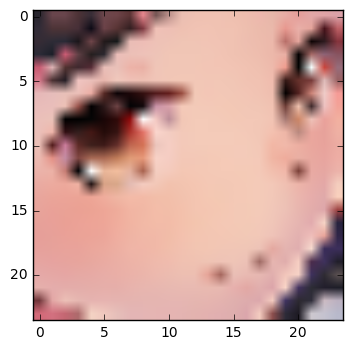

In [22]:
import matplotlib.pyplot as plt
plt.imshow((pos_db_24[10]*255).astype(np.uint8))
plt.show()

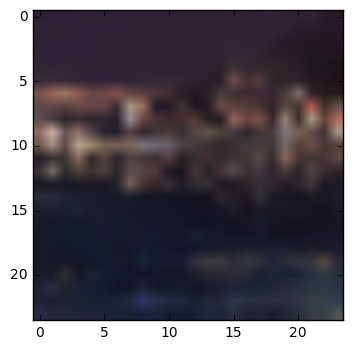

In [25]:
import matplotlib.pyplot as plt
plt.imshow((neg_db_24[101]*255).astype(np.uint8))
plt.show()